In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [16]:
# 讀取資料
file_data = r"E:\JupyterNotebooks\ANN-Classification\labeled_data.csv"
df = pd.read_csv(file_data)
subset_size = 500000  # 隨機抽取 50 萬筆資料
df_subset = df.sample(n=subset_size, random_state=42)

# 提取輸入與標籤
x = df_subset[['x', 'y']].values
y = df_subset[['label_x', 'label_y']].values

# 切分訓練集與測試集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [17]:
# 轉換為 PyTorch Tensor
def to_tensor(x, y):
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(np.argmax(y, axis=1), dtype=torch.long)  # 轉為單一標籤索引
    return x, y

x_train, y_train = to_tensor(x_train, y_train)
x_test, y_test = to_tensor(x_test, y_test)

# 建立 PyTorch DataLoader
train_dataset = data.TensorDataset(x_train, y_train)
test_dataset = data.TensorDataset(x_test, y_test)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定義 ANN 模型
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # CrossEntropyLoss 已包含 Softmax
        return x
model = ANN()

In [18]:
# 定義損失函數與優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
epochs = 50
train_losses, val_losses = [], []
train_accs, val_accs = [], []

def accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, 1)
    return (predicted == y_true).sum().item() / y_true.size(0)

for epoch in range(epochs):
    model.train()
    total_loss, total_acc = 0, 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(output, batch_y)
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(total_acc / len(train_loader))
    
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            output = model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()
            val_acc += accuracy(output, batch_y)
    val_losses.append(val_loss / len(test_loader))
    val_accs.append(val_acc / len(test_loader))
    
    print(f"Epoch {epoch+1}/{epochs} - Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

Epoch 1/50 - Loss: 0.0376, Acc: 0.9927 | Val Loss: 0.0177, Val Acc: 0.9903
Epoch 2/50 - Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0079, Val Acc: 0.9969
Epoch 3/50 - Loss: 0.0078, Acc: 0.9970 | Val Loss: 0.0069, Val Acc: 0.9972
Epoch 4/50 - Loss: 0.0069, Acc: 0.9972 | Val Loss: 0.0049, Val Acc: 0.9988
Epoch 5/50 - Loss: 0.0064, Acc: 0.9973 | Val Loss: 0.0084, Val Acc: 0.9954
Epoch 6/50 - Loss: 0.0064, Acc: 0.9973 | Val Loss: 0.0045, Val Acc: 0.9985
Epoch 7/50 - Loss: 0.0062, Acc: 0.9974 | Val Loss: 0.0053, Val Acc: 0.9976
Epoch 8/50 - Loss: 0.0060, Acc: 0.9974 | Val Loss: 0.0047, Val Acc: 0.9982
Epoch 9/50 - Loss: 0.0061, Acc: 0.9975 | Val Loss: 0.0035, Val Acc: 0.9988
Epoch 10/50 - Loss: 0.0060, Acc: 0.9974 | Val Loss: 0.0036, Val Acc: 0.9987
Epoch 11/50 - Loss: 0.0059, Acc: 0.9974 | Val Loss: 0.0037, Val Acc: 0.9984
Epoch 12/50 - Loss: 0.0057, Acc: 0.9976 | Val Loss: 0.0058, Val Acc: 0.9973
Epoch 13/50 - Loss: 0.0058, Acc: 0.9975 | Val Loss: 0.0095, Val Acc: 0.9951
Epoch 14/50 - Loss: 0

Final Test Accuracy: 0.9991


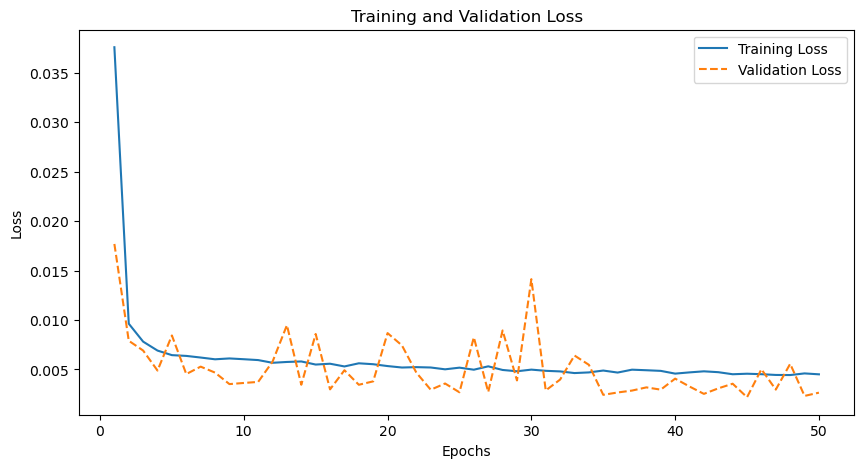

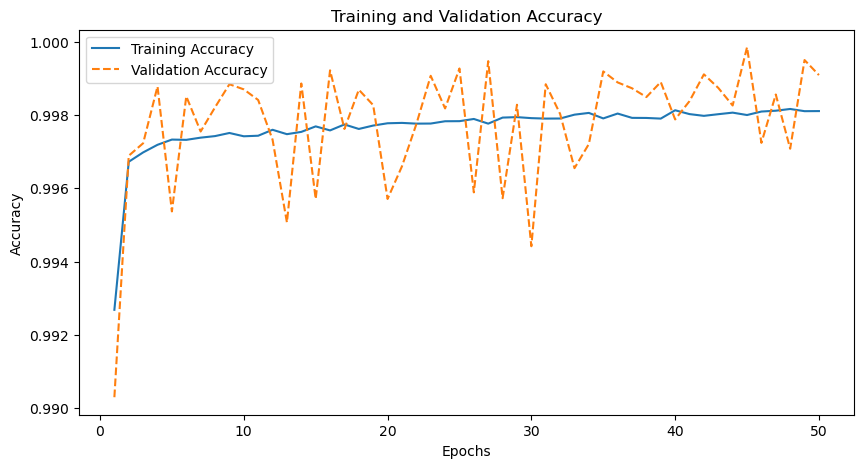

In [19]:
# 測試模型
model.eval()
with torch.no_grad():
    test_output = model(x_test)
    test_acc = accuracy(test_output, y_test)
print(f"Final Test Accuracy: {test_acc:.4f}")

# 可視化損失 & 準確率
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accs, label='Validation Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
torch.save(model.state_dict(), r"E:\JupyterNotebooks\ANN-Classification\model\ann_model.pth")